In [97]:
import numpy as np
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pandas as pd
import glob
import pickle
import os
import copy

RUNS_PATH = 'runs/'
RELATIVE_PATH = '../evolving_networks/images/frozen_experiments/'

EVOLUTION_PATH = RUNS_PATH + 'evolution_cee_shapes_features_pop_size_16_cull_interval_5000_cull_rate_0.25_e64_h64_len5_voc5_evo_mode_best/42'
CE_BEST_PATH = RUNS_PATH + 'cee_shapes_features_pop_size_16_cull_interval_5000_cull_rate_0.25_e64_h64_len5_voc5_cull_mode_best/42'
CE_RANDOM_PATH = RUNS_PATH + 'cee_shapes_features_pop_size_16_cull_interval_5000_cull_rate_0.25_e64_h64_len5_voc5_cull_mode_random/42'
CE_AGE_PATH = RUNS_PATH + 'cee_shapes_features_pop_size_16_cull_interval_5000_cull_rate_0.25_e64_h64_len5_voc5_cull_mode_age/42'

In [98]:
#get best sender/receiver paths for cee (evo and ce) from EVOLUTION_PATH and CE_PATH

def get_best_agent(population, att='acc', min_mode=False):
    """
    Helper function that goes though a list of agents and returns the one with highest mean accuracy
    """
    best_val = 0.0 if not min_mode else 100.0
    best_a = 0
    for i, agent in enumerate(population):
        val = getattr(agent, att)
        if type(val) is list:
            val = mean(val) if len(val) > 1 else best_val
        if (best_val < val and not min_mode) or (best_val > val and min_mode):
            best_a = i
            best_val = val
    return population[best_a]


def get_best_agents(folder_path, single_pool=False, **kwargs):
    # read cee.p files and go through agent attributes for one with highest val acc
    cee_files = glob.glob(folder_path+'*/cee.p')
    best_receivers = []
    best_senders = []

    for cee_file in cee_files:
        cee = pickle.load(open(cee_file, 'rb'))
        if single_pool:
            best_agent = get_best_agent(cee.agents, **kwargs)
            best_senders.append(best_agent)
            best_receivers.append(best_agent)
        else:
            best_senders.append(get_best_agent(cee.senders, **kwargs))
            best_receivers.append(get_best_agent(cee.receivers, **kwargs))

    best_sender = get_best_agent(best_senders)
    best_receiver = get_best_agent(best_receivers)
    
    return (best_sender, best_receiver)

evo_sender, evo_receiver = get_best_agents(EVOLUTION_PATH)
ce_best_sender, ce_best_receiver = get_best_agents(CE_BEST_PATH)
ce_random_sender, ce_random_receiver = get_best_agents(CE_RANDOM_PATH)
ce_age_sender, ce_age_receiver = get_best_agents(CE_AGE_PATH)

def print_agent_info(agent, mode):
    print("{} agent{}: loss:{}, acc: {}, conv: {}, age: {}".format(mode, agent.agent_id,
                                                  mean(agent.loss),
                                                  mean(agent.acc),
                                                  agent.convergence,
                                                  agent.age)) 

print("Selected Senders")
print_agent_info(evo_sender, 'evolution')
print_agent_info(ce_best_sender, 'ce_best')
print_agent_info(ce_random_sender, 'ce_random')
print_agent_info(ce_age_sender, 'ce_age')

print("Selected Receivers")
print_agent_info(evo_receiver, 'evolution')
print_agent_info(ce_best_receiver, 'ce_best')
print_agent_info(ce_random_receiver, 'ce_random')
print_agent_info(ce_age_receiver, 'ce_age')

Selected Senders
evolution agent3: loss:0.148806416142303, acc: 0.9543530178686934, conv: 1.135762631734635, age: 19325
ce_best agent12: loss:0.1434940176588223, acc: 0.9541562334671989, conv: 1.4838681525372444, age: 31188
ce_random agent10: loss:0.3029701387453111, acc: 0.9195771755284016, conv: 3.907272608280182, age: 3785
ce_age agent0: loss:0.7282984418543735, acc: 0.8424241633478932, conv: 4.215336600542068, age: 973
Selected Receivers
evolution agent0: loss:0.35963567176595274, acc: 0.9187528368239468, conv: 0.4213404024453604, age: 24166
ce_best agent11: loss:0.6241196287243524, acc: 0.8822149237662942, conv: 0.5662115918701155, age: 21480
ce_random agent8: loss:0.5203368750164163, acc: 0.8822531471282454, conv: 0.984558435678482, age: 1271
ce_age agent2: loss:0.5706993595035439, acc: 0.867678381256656, conv: 0.9981042408943176, age: 939


In [99]:
#get 'best' baseline sender/receiver by pretraining
from baseline import baseline

# Run baseline LSTM model if not exists
model_name = RUNS_PATH+'lstm_architecture_baseline'
if not os.path.isdir(model_name):   
    params = ['--iterations', '10000', '--log-interval', '500', 
              '--name', 'lstm_architecture_baseline']
    model_name = baseline(params)
baseline_sender_filename = model_name+'/sender.p'
baseline_receiver_filename = model_name+'/receiver.p'

In [100]:
# Run baseline model using best evolved architecture if not exists
model_name = RUNS_PATH+'best_evolved_architecture_baseline'
if not os.path.isdir(model_name):   
    params = ['--iterations', '10000', '--log-interval', '500', 
              '--sender-path', evo_sender.filename, 
              '--receiver-path', evo_receiver.filename,
              '--name', 'best_evolved_architecture_baseline']
    model_name = baseline(params)
baseline_evo_sender_filename = model_name+'/sender.p'
baseline_evo_receiver_filename = model_name+'/receiver.p'

# Baseline experiments (freezing either sender or receiver) 
Here we test the effect of the different sender or receiver models obtained from CE / Evolution / Baseline (2 agent setup) in transferring the knowledge to a newly initialized basline LSTM model. 


In [101]:
MAX_ITERATIONS = 2500
def get_metrics_from_folders(folder_paths):
    """
    Helper function to get metrics from list of experiment folders, and return as whole
    """
    results = {}
    for i, f_path in enumerate(folder_paths):
        results[i] = {}
        saved_metrics = glob.glob("{}/metrics*.p".format(f_path))
        for m in saved_metrics:
            iteration = int(m.split("_")[-1].split(".")[0])
            p=pickle.load(open(m, 'rb'))
            results[i][iteration] = p
    return results

def plot_metric(results, metrics=["avg_convergence"], ylabel=None, show_error=True, 
                savefig=True, figname=None, ylim=False, title=None):
    
    ci = 'sd' if show_error else None
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    
    run_names = []
    metric_names = []
    iterations = []
    values = []
    
    for m in metrics:
        for r in list(results.keys()):
            for s in list(results[r].keys()):
                for iteration_number in sorted(list(results[r][s].keys())):
                    if iteration_number == 0:
                        continue
                    if iteration_number < MAX_ITERATIONS:
                        iterations.append(iteration_number)
                        values.append(results[r][s][iteration_number][m])
                        run_names.append(r)
                        metric_names.append(m)
            
    values = np.array(values)
    iterations = np.array(iterations)        
    if len(metrics) < 2:     
        d = {'Number of Iterations': iterations, m: values, 'run_name': run_names, 'metric_name': metric_names}
        ax = sns.lineplot(ax=ax, x='Number of Iterations', y=m, data=pd.DataFrame(data=d), 
                          style='run_name' if len(list(results.keys())) < 7 else None, 
                          hue='run_name', ci=ci)
        if ylabel is None:
            ylabel = m
    else:
        d = {'Number of Iterations': iterations, 'val': values, 'run_name': run_names, 'metric_name': metric_names}
        ax = sns.lineplot(ax=ax, x='Number of Iterations', y='val', data=pd.DataFrame(data=d), style="metric_name", hue="run_name", ci=ci)
        if ylabel is None:
            ylabel = "val"
        
    ax.set(xlabel='Number of Iterations', ylabel=ylabel)
    if ylim:
        ax.set(ylim=ylim)
    if title is not None:
        ax.set_title(title)

    if savefig:
        if figname is None:
            figname = ylabel
        if title is not None:
            figname = title.lower().replace(' ', '_')
        plt.savefig(RELATIVE_PATH+figname)
        
    plt.show()

In [102]:
import random

def run_experiments(agent_model=None, freeze=True, num_runs=10, 
                    exp_name='baseline', overwrite=False, receiver=False,
                    random_evolution=False, paired_model=None):
    """
    sample num_runs different models to pair with agent_model
    returns metrics from all runs
    """

    mode = 'receiver' if receiver else 'sender'
    exp_dir = '{}_experiments'.format(mode)
    seeds = list(range(num_runs))
    folders = []
    defaults = []
    #sample random model to pair with agent model
    if random_evolution:
        defaults += ['--darts', ]
        exp_dir = 'diversity_' + exp_dir

    # used paired model (reinitialized) to pair with agent model
    if paired_model is not None:
        exp_dir = 'evo_' + exp_dir
        opp_mode = 'sender' if receiver else 'receiver'
        defaults += ['--{}-path'.format(opp_mode), paired_model]
    
    for s in tqdm_notebook(seeds): 
        run_name = '{}_{}'.format(exp_name, s)
        params = defaults

        if random_evolution:
            random.seed(s)
            num_nodes = random.randint(1,8)
            params += ['--num-nodes', str(num_nodes)]

        if os.path.isdir(RUNS_PATH+exp_dir+'/'+run_name) and not overwrite:
            folder = RUNS_PATH+exp_dir+'/'+run_name
        else:             
            params += ['--iterations', str(MAX_ITERATIONS), '--log-interval', '100',
                       '--disable-print','--name', run_name,
                       '--folder', exp_dir, '--seed', str(s)]

            # agent model path (if not passed then just runs lstm base)
            if agent_model is not None:
                params += ['--{}-path'.format(mode), agent_model]
                
            # freeze the agent_model in order to analyze its impact
            if freeze:
                params += ['--freeze-{}'.format(mode)]

            folder = baseline(params)

        folders.append(folder)
    return get_metrics_from_folders(folders)

## LSTM base
### Sample different baseline (LSTM) receiver models:
Train different LSTM Receivers with frozen baseline_sender, best_evo_sender, best_ce_sender, and from scratch


In [103]:
NUM_BASELINE_RUNS = 5


In [104]:
sender_results = {}
sender_results['baseline'] = run_experiments(freeze=False)
sender_results['baseline_pretrained'] = run_experiments(agent_model=baseline_sender_filename, 
                                                        exp_name='baseline_pretrained')
sender_results['ce_best'] = run_experiments(agent_model=ce_best_sender.filename, 
                                            exp_name="ce_best", num_runs=NUM_BASELINE_RUNS)
sender_results['ce_age'] = run_experiments(agent_model=ce_age_sender.filename, 
                                           exp_name="ce_age", num_runs=NUM_BASELINE_RUNS)
sender_results['ce_random'] = run_experiments(agent_model=ce_random_sender.filename, 
                                              exp_name="ce_random", num_runs=NUM_BASELINE_RUNS)

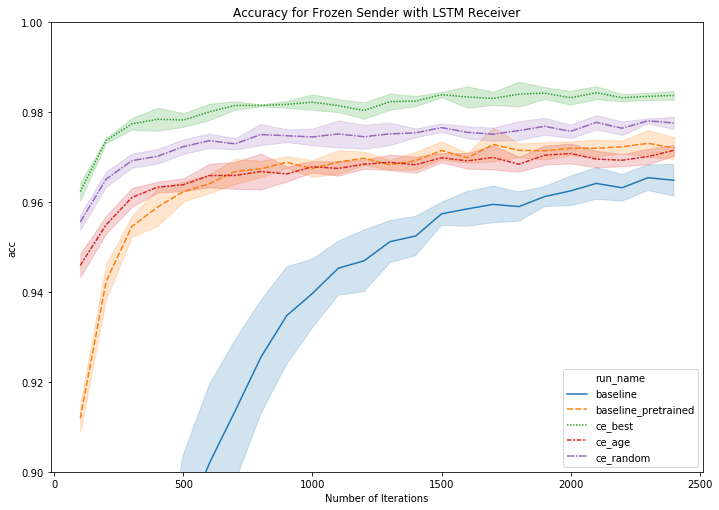

In [105]:
plot_metric(sender_results, metrics=['acc'], show_error=True, ylim=(0.9, 1.0), title="Accuracy for Frozen Sender with LSTM Receiver")

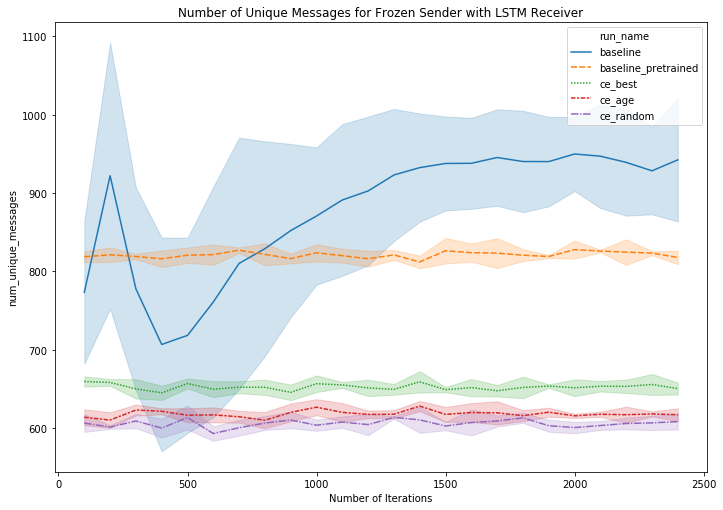

In [106]:
plot_metric(sender_results, metrics=['num_unique_messages'], show_error=True, title="Number of Unique Messages for Frozen Sender with LSTM Receiver", )

### Sample different baseline (LSTM) sender models:

train with frozen baseline_receiver, best_evo_receiver, best_ce_receiver, and from scratch

In [107]:
receiver_results ={}
receiver_results['baseline'] = run_experiments(freeze=False)
receiver_results['baseline_pretrained'] = run_experiments(agent_model=baseline_receiver_filename, 
                                                          exp_name='baseline_pretrained', 
                                                          receiver=True)
receiver_results['ce_best'] = run_experiments(agent_model=ce_best_receiver.filename, exp_name="ce_best",
                                              num_runs=NUM_BASELINE_RUNS, receiver=True)
receiver_results['ce_age'] = run_experiments(agent_model=ce_age_receiver.filename, exp_name="ce_age", 
                                             num_runs=NUM_BASELINE_RUNS, receiver=True)
receiver_results['ce_random'] = run_experiments(agent_model=ce_random_receiver.filename, exp_name="ce_random", 
                                                num_runs=NUM_BASELINE_RUNS, receiver=True)

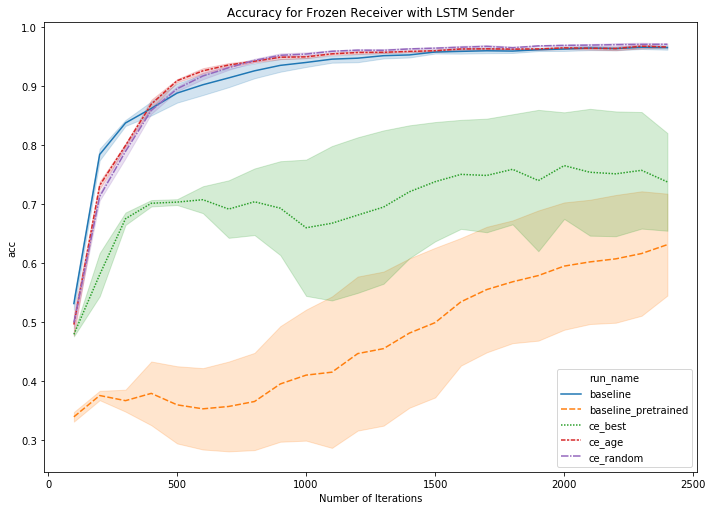

In [108]:
plot_metric(receiver_results, metrics=['acc'], show_error=True, title="Accuracy for Frozen Receiver with LSTM Sender")

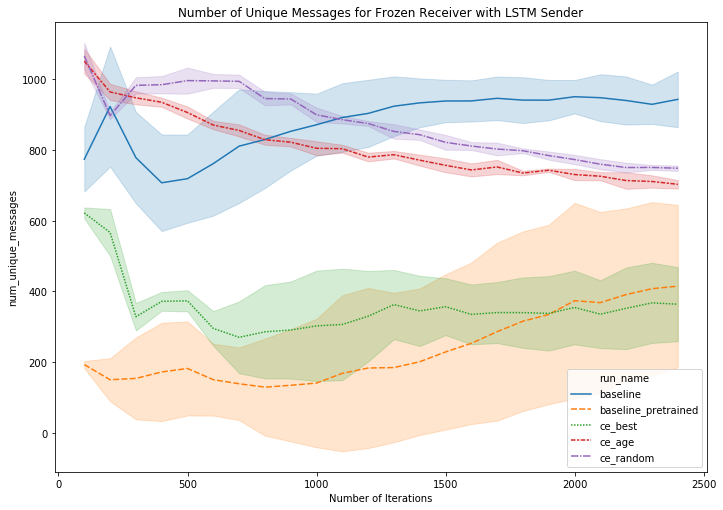

In [109]:
plot_metric(receiver_results, metrics=['num_unique_messages'], show_error=True, title="Number of Unique Messages for Frozen Receiver with LSTM Sender")

## Evolved base
### Sample different evolved receiver models:

train with frozen baseline_sender, best_evo_sender and from scratch using the best evolved architectures

In [110]:
evo_sender_results = {}
EVO_NUM_RUNS = 5
evo_sender_results['baseline'] = run_experiments(agent_model=evo_sender.filename, exp_name="baseline", 
                                                 num_runs=EVO_NUM_RUNS, freeze=False, 
                                                 paired_model=evo_receiver.filename)
evo_sender_results['baseline_pretrained'] = run_experiments(agent_model=baseline_evo_sender_filename, 
                                                            exp_name="baseline_pretrained", 
                                                            num_runs=EVO_NUM_RUNS,
                                                            paired_model=evo_receiver.filename)
evo_sender_results['evolution'] = run_experiments(agent_model=evo_sender.filename, 
                                                  exp_name="evolution", 
                                                  num_runs=EVO_NUM_RUNS,
                                                  paired_model=evo_receiver.filename)

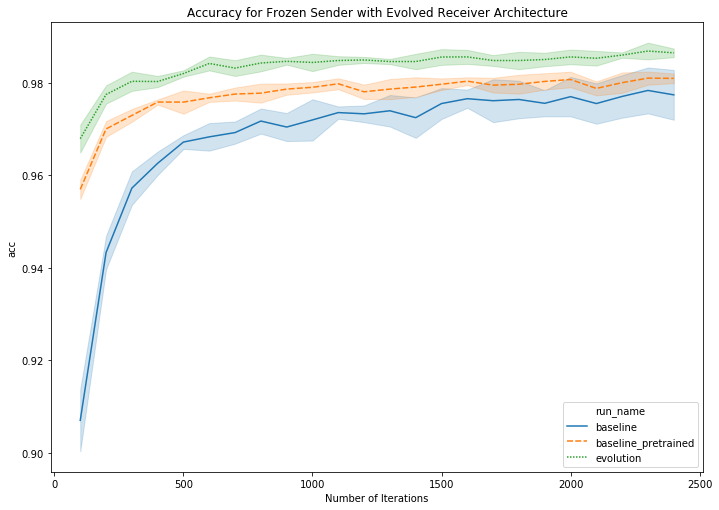

In [111]:
plot_metric(evo_sender_results, metrics=['acc'], show_error=True, title="Accuracy for Frozen Sender with Evolved Receiver Architecture")

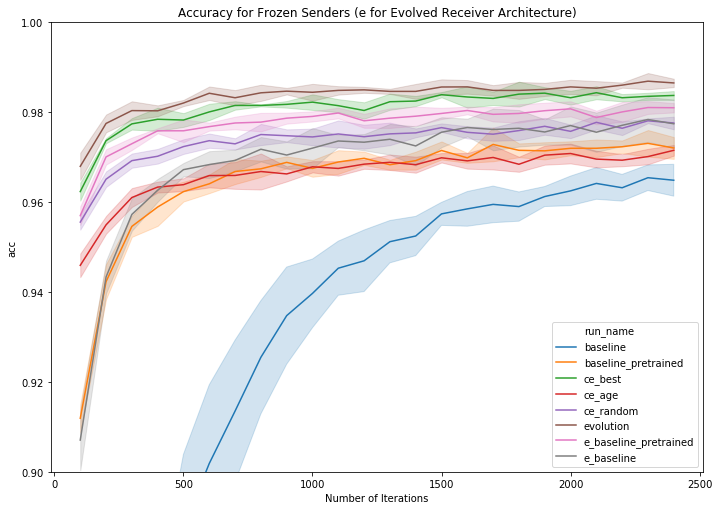

In [112]:
# Combined plot
combined_sender_results = copy.deepcopy(sender_results)
combined_sender_results['evolution'] = evo_sender_results['evolution']
combined_sender_results['e_baseline_pretrained'] = evo_sender_results['baseline_pretrained']
combined_sender_results['e_baseline'] = evo_sender_results['baseline']


plot_metric(combined_sender_results, metrics=['acc'], 
            show_error=True, ylim=(0.9, 1.0), 
            title="Accuracy for Frozen Senders (e for Evolved Receiver Architecture)")

### Sample different evolved sender models:

train with frozen baseline_receiver, best_evo_receiver and from scratch using the best evolved architectures

In [113]:
evo_receiver_results = {}
evo_receiver_results['baseline'] = run_experiments(agent_model=evo_receiver.filename, exp_name="baseline", 
                                                   num_runs=EVO_NUM_RUNS, freeze=False, 
                                                   paired_model=evo_sender.filename)
evo_receiver_results['baseline_pretrained'] = run_experiments(agent_model=baseline_evo_receiver_filename, 
                                                              exp_name="baseline_pretrained", 
                                                              num_runs=EVO_NUM_RUNS,
                                                              paired_model=evo_sender.filename,
                                                              receiver=True)
evo_receiver_results['evolution'] = run_experiments(agent_model=evo_receiver.filename, 
                                                    exp_name="evolution", 
                                                    num_runs=EVO_NUM_RUNS,
                                                    paired_model=evo_sender.filename,
                                                    receiver=True)

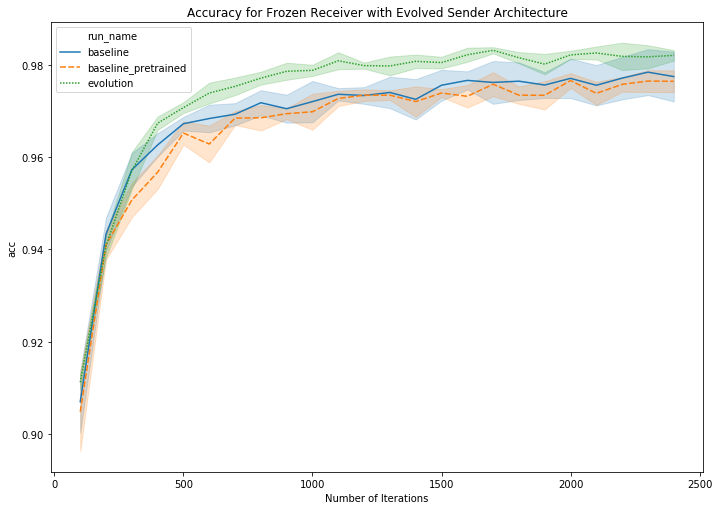

In [114]:
plot_metric(evo_receiver_results, metrics=['acc'], show_error=True, title="Accuracy for Frozen Receiver with Evolved Sender Architecture")

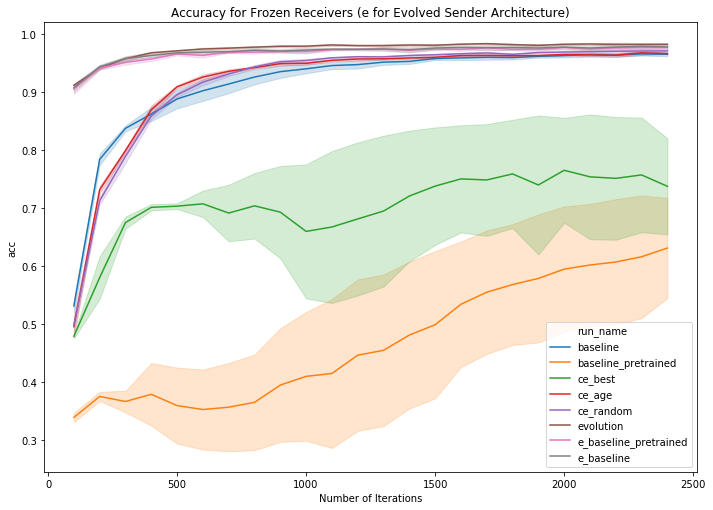

In [115]:
# Combined plot
combined_receiver_results = copy.deepcopy(receiver_results)
combined_receiver_results['evolution'] = evo_receiver_results['evolution']
combined_receiver_results['e_baseline_pretrained'] = evo_receiver_results['baseline_pretrained']
combined_receiver_results['e_baseline'] = evo_receiver_results['baseline']


plot_metric(combined_receiver_results, metrics=['acc'], 
            show_error=True, 
            title="Accuracy for Frozen Receivers (e for Evolved Sender Architecture)")

## Sensitivity to Diversity Experiments - Random Architecture base
### Sample random darts receiver models (freeze sender)

Train with frozen baseline_sender, best_evo_sender, best_ce_sender, ... etc and from scratch 

In [116]:
NUM_DIVERSITY_RUNS = 5
div_sender_results = {}
div_sender_results['baseline'] = run_experiments(agent_model=evo_sender.filename, exp_name="baseline", 
                                                 num_runs=NUM_DIVERSITY_RUNS, freeze=False, 
                                                 random_evolution=True)
div_sender_results['baseline_pretrained'] = run_experiments(agent_model=baseline_evo_sender_filename, 
                                                            exp_name="baseline_pretrained", 
                                                            num_runs=NUM_DIVERSITY_RUNS,
                                                            random_evolution=True)
div_sender_results['evolution'] = run_experiments(agent_model=evo_sender.filename, 
                                                  exp_name="evolution",
                                                  num_runs=NUM_DIVERSITY_RUNS,
                                                  random_evolution=True)

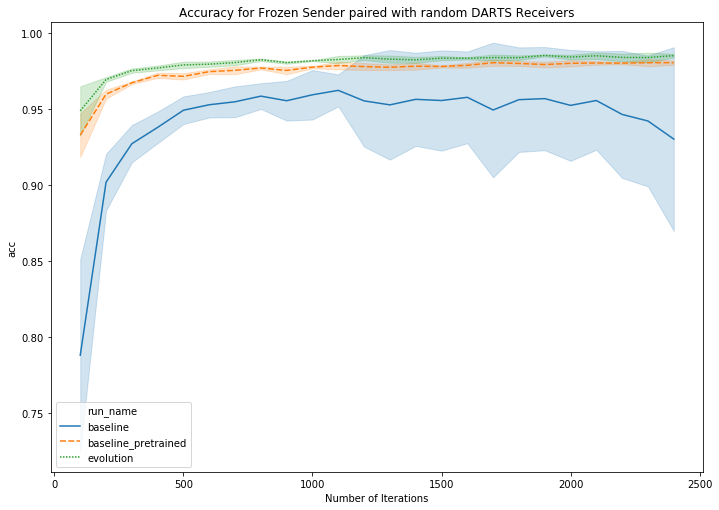

In [117]:
plot_metric(div_sender_results, metrics=['acc'], show_error=True, title="Accuracy for Frozen Sender paired with random DARTS Receivers")

### Sample random darts sender models (freeze receiver)

Train with frozen baseline_sender, best_evo_sender, best_ce_sender, ... etc and from scratch 

In [118]:
div_receiver_results = {}
div_receiver_results['baseline'] = run_experiments(agent_model=evo_receiver.filename, exp_name="baseline", 
                                                   num_runs=NUM_DIVERSITY_RUNS, freeze=False, 
                                                   random_evolution=True)
div_receiver_results['baseline_pretrained'] = run_experiments(agent_model=baseline_evo_receiver_filename, 
                                                            exp_name="baseline_pretrained", 
                                                            num_runs=NUM_DIVERSITY_RUNS,
                                                            random_evolution=True,
                                                            receiver=True)
div_receiver_results['evolution'] = run_experiments(agent_model=evo_receiver.filename, 
                                                    exp_name="evolution", 
                                                    num_runs=NUM_DIVERSITY_RUNS,
                                                    random_evolution=True,
                                                    receiver=True)

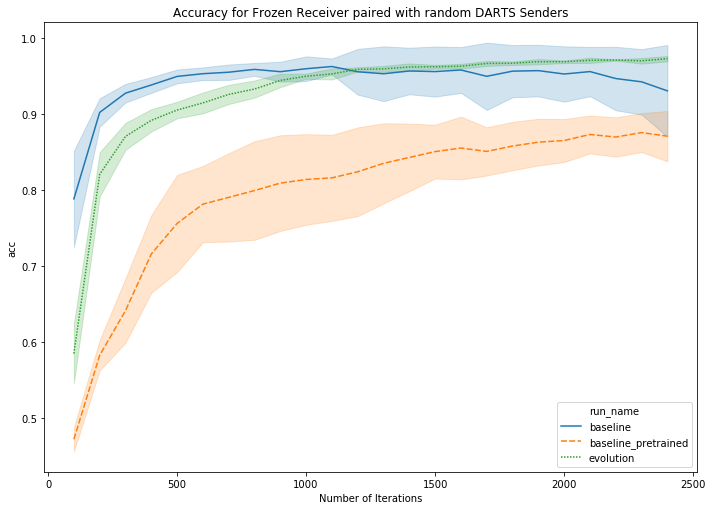

In [119]:
plot_metric(div_receiver_results, metrics=['acc'], show_error=True, title="Accuracy for Frozen Receiver paired with random DARTS Senders")